In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.weightstats import *
from scipy import stats
import pylab
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
data = pd.read_csv('credit_card_default_analysis.csv')

### Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:
#### a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

In [29]:
data_0 = data[data['default'] == 0]
data_1 = data[data['default'] == 1]

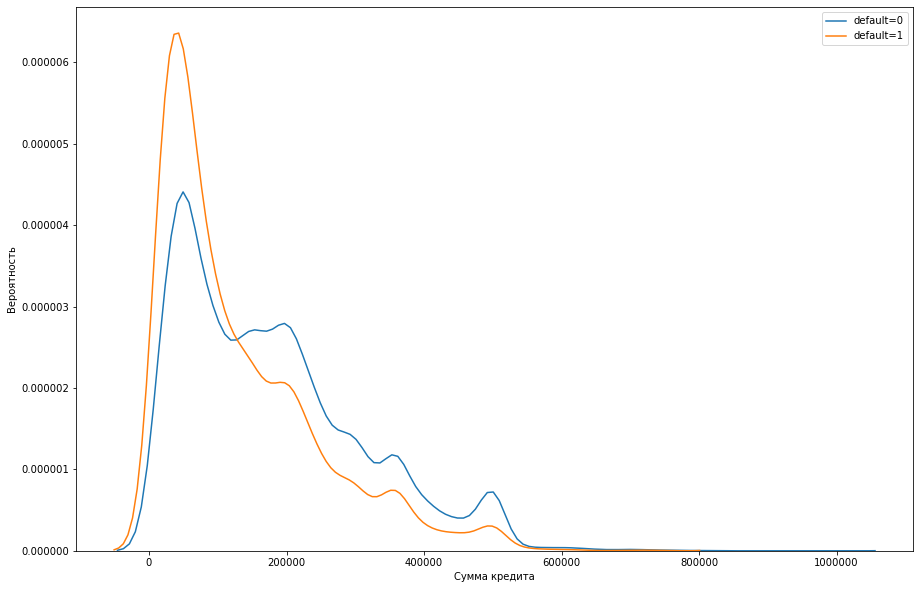

In [4]:
plt.figure(figsize=(15, 10))
sns.kdeplot(data_0['LIMIT_BAL'], label='default=0')
sns.kdeplot(data_1['LIMIT_BAL'], label='default=1')
plt.xlabel("Сумма кредита")
plt.ylabel("Вероятность")
plt.show()

In [100]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

defolt_0 = data_0['LIMIT_BAL'].values
defolt_1 = data_1['LIMIT_BAL'].values

np.random.seed(0)

defolt_0_median_scores = list(map(np.median, get_bootstrap_samples(defolt_0, 1000)))
defolt_1_median_scores = list(map(np.median, get_bootstrap_samples(defolt_1, 1000)))

print("95% доверительный интервал для defolt_0 медианного кредитного лимита:",  stat_intervals(defolt_0_median_scores, 0.05))
print("95% доверительный интервал для defolt_1 медианного кредитного лимита:",  stat_intervals(defolt_1_median_scores, 0.05))

95% доверительный интервал для defolt_0 медианного кредитного лимита: [150000. 150000.]
95% доверительный интервал для defolt_1 медианного кредитного лимита: [80000. 90000.]


Распределения похожи на нормальные, можно применить Критерий Стьюдента

$H_0\colon$ средние значения суммы кредита одинаковы для людей вернувших и не вернувших креди

$H_0\colon$ не одинаковы.

In [101]:
pvalue = stats.ttest_ind(defolt_0, defolt_1, equal_var=False).pvalue
print('Уровень значимости = {:.4f}'.format(pvalue))
print('Гипотеза отвергается')

Уровень значимости = 0.0000
Гипотеза отвергается


#### b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [102]:
pvalue = stats.mannwhitneyu(defolt_0, defolt_1).pvalue
print('Уровень значимости = {:.4f}'.format(pvalue))
print('Гипотеза отвергается')

Уровень значимости = 0.0000
Гипотеза отвергается


Результаты значимы с практической точки зрения так как позволяют сделать вывод о том что средняя сумма займа у двух групп различна

### Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [33]:
data_sex_1 = data[data['SEX'] == 1]['default']
data_sex_2 = data[data['SEX'] == 2]['default']

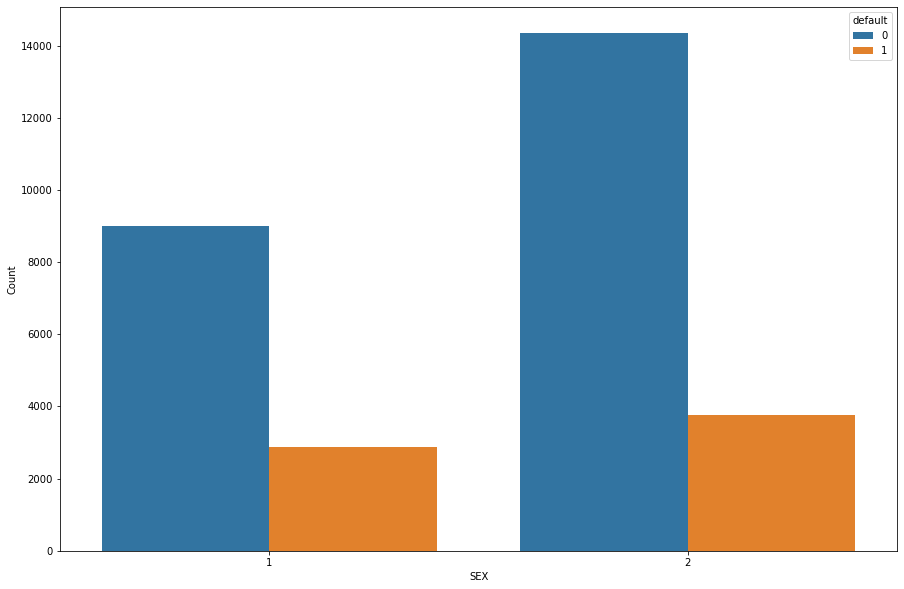

In [34]:
plt.figure(figsize=(15, 10))
sns.countplot(x='SEX', hue='default', data=data)
plt.xlabel("SEX")
plt.ylabel("Count")
plt.show()

In [38]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

Так как выборки независимые потому, что описывают разные объекты, то можно применить Z-критерий для разности долей для независимых выборок:

$H_0\colon$ нет гендерных различий для людей вернувших и не вернувших креди

$H_0\colon$ различия есть

In [103]:
interval = proportions_diff_confint_ind(data_sex_1, data_sex_2)
print('95% доверительный интервал для разности долей: [{}, {}]'.format(interval[0], interval[1]))

95% доверительный интервал для разности долей: [0.024207372179792706, 0.0436115585708172]


In [104]:
pvalue = proportions_diff_z_test(proportions_diff_z_stat_ind(data_sex_1, data_sex_2))
print('Уровень значимости = {:.4f}'.format(pvalue))
print('Гипотеза отвергается')

Уровень значимости = 0.0000
Гипотеза отвергается


### Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [74]:
counts = data.groupby(['default', 'EDUCATION']).size()
pivot = pd.DataFrame([counts[0], counts[1]])
pivot / pivot.sum()

EDUCATION,0,1,2,3,4,5,6
0,1.0,0.807652,0.762651,0.748424,0.943089,0.935714,0.843137
1,NaN,0.192348,0.237349,0.251576,0.056911,0.064286,0.156863


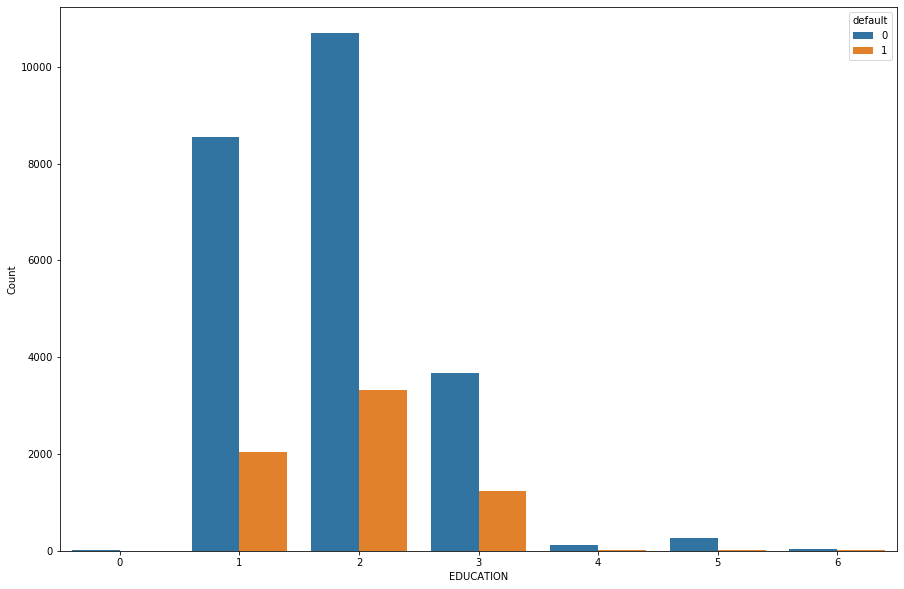

In [76]:
plt.figure(figsize=(15, 10))
sns.countplot(x='EDUCATION', hue='default', data=data)
plt.xlabel("EDUCATION")
plt.ylabel("Count")
plt.show()

In [106]:
observed_frequences = np.bincount(data['EDUCATION'])
observed_frequences

array([   14, 10585, 14030,  4917,   123,   280,    51])

In [109]:
l = data['EDUCATION'].mean()
expected_frequences = [data.shape[0] * stats.poisson.pmf(x, l) for x in range(data['EDUCATION'].min(), data['EDUCATION'].max() + 1)]
expected_frequences

[4702.3578274027,
 8714.096035220855,
 8074.190916367805,
 4987.517442272797,
 2310.6337057142828,
 856.3824682365326,
 264.498482995232]

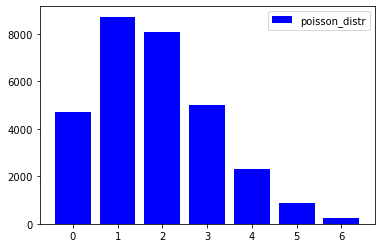

In [113]:
pylab.bar(range(len(expected_frequences)), expected_frequences, color = 'b', label = 'poisson_distr')
pylab.legend()

In [119]:
observed_frequences - expected_frequences

array([-4688.3578274 ,  1870.90396478,  5955.80908363,   -70.51744227,
       -2187.63370571,  -576.38246824,  -213.498483  ])

$H_0\colon$ распределение хи-квадрат с числом степеней свободы  𝐾−1−𝑚 

$H_0\colon$ другое

In [118]:
pvalue = stats.chisquare(observed_frequences, expected_frequences, ddof=1).pvalue
print('Уровень значимости = {:.4f}'.format(pvalue))
print('Гипотеза отвергается')

Уровень значимости = 0.0000
Гипотеза отвергается


### Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [85]:
counts = data.groupby(['default', 'MARRIAGE']).size()
pivot = pd.DataFrame([counts[0], counts[1]])
pivot / pivot.sum()

MARRIAGE,0,1,2,3
0,0.907407,0.765283,0.790717,0.739938
1,0.092593,0.234717,0.209283,0.260062


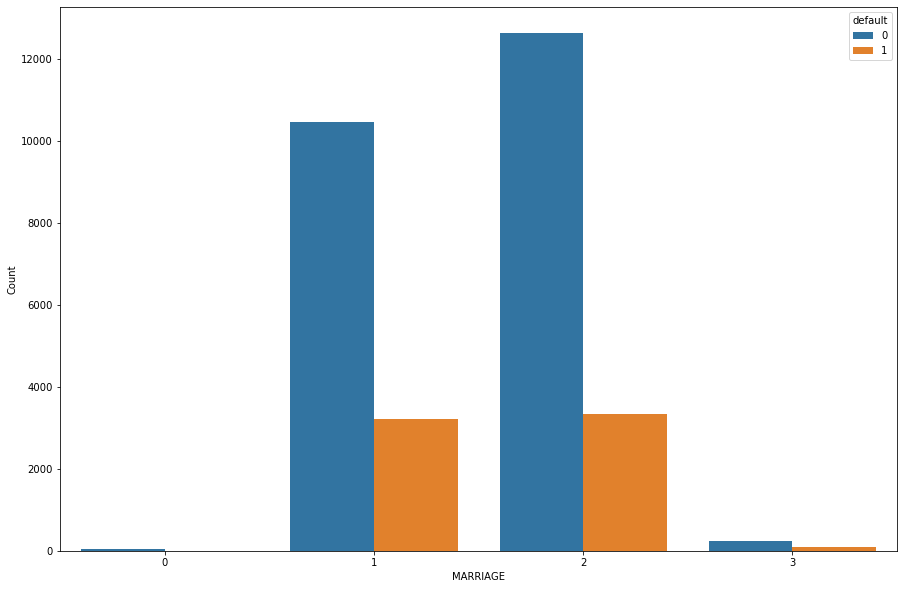

In [87]:
plt.figure(figsize=(15, 10))
sns.countplot(x='MARRIAGE', hue='default', data=data)
plt.xlabel("MARRIAGE")
plt.ylabel("Count")
plt.show()

In [120]:
observed_frequences = np.bincount(data['MARRIAGE'])
observed_frequences

array([   54, 13659, 15964,   323])

In [121]:
l = data['MARRIAGE'].mean()
expected_frequences = [data.shape[0] * stats.poisson.pmf(x, l) for x in range(data['MARRIAGE'].min(), data['MARRIAGE'].max() + 1)]
expected_frequences

[6355.564414862694, 9862.988563278253, 7653.021592533039, 3958.8230362440913]

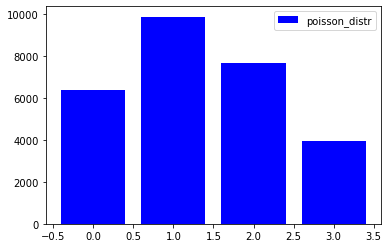

In [122]:
pylab.bar(range(len(expected_frequences)), expected_frequences, color = 'b', label = 'poisson_distr')
pylab.legend()

In [139]:
conf_table = np.empty((data['MARRIAGE'].unique().shape[0], 2))
for i in range(conf_table.shape[0]):
    conf_table[i, 0] = (data_0['MARRIAGE'] == i).sum()
    conf_table[i, 1] = (data_1['MARRIAGE'] == i).sum()
conf_table

array([[4.9000e+01, 5.0000e+00],
       [1.0453e+04, 3.2060e+03],
       [1.2623e+04, 3.3410e+03],
       [2.3900e+02, 8.4000e+01]])

In [141]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

print('V Крамера статистика: %.4f' % cramers_stat(conf_table))

V Крамера статистика: 0.0345


Коэффициент Крамера принимает значение, близкое к нулю, когда взаимосвязь отсутствует.

Практическая значимость в данном результате также присутствует, т.к. исходя из этих данных нет разницы в том, с каким статусом MARRIAGE приходит человек за кредитом.

### Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей

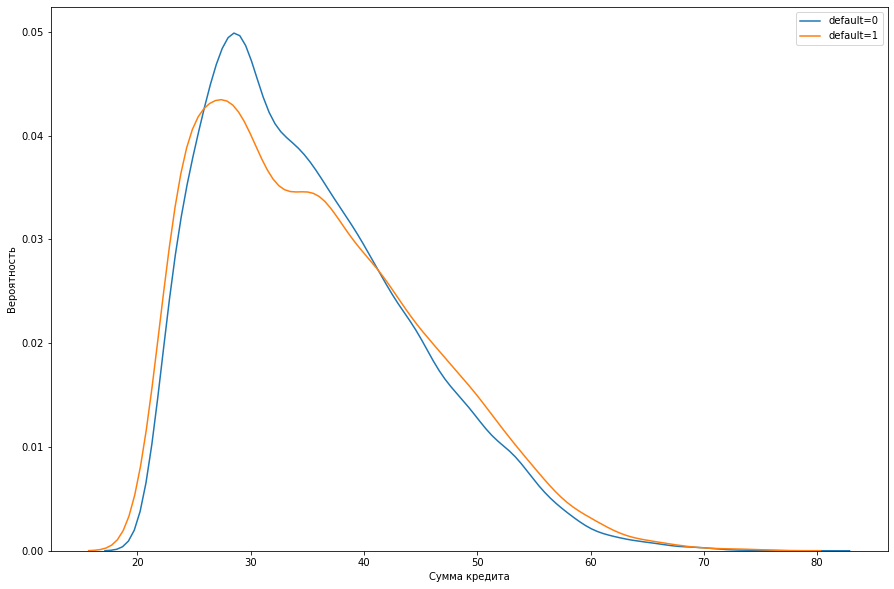

In [123]:
plt.figure(figsize=(15, 10))
sns.kdeplot(data_0['AGE'], label='default=0')
sns.kdeplot(data_1['AGE'], label='default=1')
plt.xlabel("Сумма кредита")
plt.ylabel("Вероятность")
plt.show()

In [124]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

defolt_0 = data_0['AGE'].values
defolt_1 = data_1['AGE'].values

np.random.seed(0)

defolt_0_median_scores = list(map(np.median, get_bootstrap_samples(defolt_0, 1000)))
defolt_1_median_scores = list(map(np.median, get_bootstrap_samples(defolt_1, 1000)))

print("95% доверительный интервал для defolt_0 медианного возраста:",  stat_intervals(defolt_0_median_scores, 0.05))
print("95% доверительный интервал для defolt_1 медианного возраста:",  stat_intervals(defolt_1_median_scores, 0.05))

95% доверительный интервал для defolt_0 медианного возраста: [34. 34.]
95% доверительный интервал для defolt_1 медианного возраста: [34. 35.]


Распределения похожи на нормальные, можно применить Критерий Стьюдента

$H_0\colon$ средние значения суммы кредита одинаковы для людей вернувших и не вернувших креди

$H_0\colon$ не одинаковы.

In [127]:
pvalue = stats.ttest_ind(defolt_0, defolt_1, equal_var=False).pvalue
print('Уровень значимости = {:.4f}'.format(pvalue))
print('Гипотеза отвергается')

Уровень значимости = 0.0204
Гипотеза отвергается


###  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [152]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_test(sample1, sample2, max_permutations=None, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

$H_0\colon 0$ распределения выборок полностью равны

$H_1\colon 0$ не равны

In [153]:
pvalue = permutation_test(defolt_0, defolt_1, max_permutations=1000)
print('Уровень значимости = {:.4f}'.format(pvalue))
print('Гипотеза не отвергается')

Уровень значимости = 0.0170
Гипотеза не отвергается


Результаты значимы с практической точки зрения так как позволяют сделать вывод о том что средний возраст у двух групп одинаков